In [1]:
from pandas_datareader import data  # You will need to run "pip install pandas_datareader"
import holidays   # You will need to run "pip install holidays"
import datetime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Useful resources:

https://readthedocs.org/projects/pandas-datareader/downloads/pdf/latest/

https://www.investopedia.com/terms/c/consumerpriceindex.asp

https://www.investopedia.com/insights/understanding-consumer-confidence-index/

https://fred.stlouisfed.org/series

In [2]:
ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()

def previous_business_day(specific_date):
    previous_day = specific_date - ONE_DAY
    while previous_day.weekday() in holidays.WEEKEND or previous_day in HOLIDAYS_US:
        previous_day -= ONE_DAY
    return previous_day

def next_business_day(specific_date):
    next_day = specific_date + ONE_DAY
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

In [3]:
def get_historical_data(share, start_date='2019-01-02', end_date='2019-12-31', source='yahoo'):
    try:
        panel_data = data.DataReader(share, source, start_date, end_date)
    except: 
        panel_data = pd.DataFrame()
    return panel_data

In [4]:
def compute_average_annual_return(share, start_date='2019-01-02', end_date='2019-12-31', source='yahoo'):
    panel_data = get_historical_data(share, start_date, end_date, source)
    if panel_data.empty:
        return None, None, None, None, None
    
    adj_close = panel_data['Adj Close']
    
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    
    while start_date.strftime('%Y-%m-%d') not in adj_close.index: 
        start_date = next_business_day(start_date)
    
    while end_date.strftime('%Y-%m-%d') not in adj_close.index: 
        end_date = previous_business_day(end_date)
    
    delta = end_date - start_date
    years = delta.days / 365
    
    start_price = adj_close.loc[start_date.strftime('%Y-%m-%d')]
    end_price = adj_close.loc[end_date.strftime('%Y-%m-%d')]
    
    return_value = (end_price/start_price)**(1/years) - 1
    return round(return_value, 4), start_date, end_date, delta, years

In [5]:
def compute_daily_return_std_per_year(share, start_date='2019-01-02', end_date='2019-12-31', source='yahoo'):
    panel_data = get_historical_data(share, start_date, end_date, source)
    if panel_data.empty:
        return None
    
    last_day_price = None
    daily_returns = [] 
    for index, row in panel_data.iterrows():
        if last_day_price:
            daily_returns.append(row['Adj Close']/last_day_price - 1)
        last_day_price = row['Adj Close']
    return round(np.std(daily_returns)*np.sqrt(252), 4)

In [6]:
def compute_sharpe(share, start_date='2019-01-02', end_date='2019-12-31', source='yahoo'):
    avg, _, _, _, _ = compute_average_annual_return(share, start_date, end_date, source)
    std = compute_daily_return_std_per_year(share, start_date, end_date, source)
    if not avg or not std:
        return 
    return round(avg/std, 4)

In [7]:
SP_500 = pd.read_excel('SP_500.xlsx', index_col=0)
SP_500_symbol_list = SP_500.index.to_list()[:-2]

In [8]:
iTickers = {}
iTickers["SPY"] = "SPDR S&P 500 ETF Trust"
iTickers["VOO"] = "Vanguard S&P 500 ETF"
iTickers["VTI"] = "Vanguard Total Stock Market ETF"
iTickers["BRK-B"] = "Berkshire Hathaway Inc."
iTickers["AAPL"] = "Apple Inc."
iTickers["BAC"] = "Bank of America"
iTickers["MSFT"] = "Microsoft"
iTickers["IVV"] = "iShares Core S&P 500 ETF"
iTickers["NFLX"] = "Netflix"

In [ ]:
for symb in SP_500_symbol_list:  
    print("---------------\n", symb)
    sharpe_ratio = compute_sharpe(symb)
    print(SP_500.loc[symb]['Name'], sharpe_ratio)

SPDR S&P 500 ETF Trust
SPDR S&P 500 ETF Trust 2.5004
Vanguard S&P 500 ETF
Vanguard S&P 500 ETF 2.5269
Vanguard Total Stock Market ETF
Vanguard Total Stock Market ETF 2.4393
Berkshire Hathaway Inc.
Berkshire Hathaway Inc. 0.7833
Apple Inc.
Apple Inc. 3.42
Bank of America
Bank of America 1.9287
Microsoft
Microsoft 2.9596
iShares Core S&P 500 ETF
iShares Core S&P 500 ETF 2.5012
Netflix
Netflix 0.6069


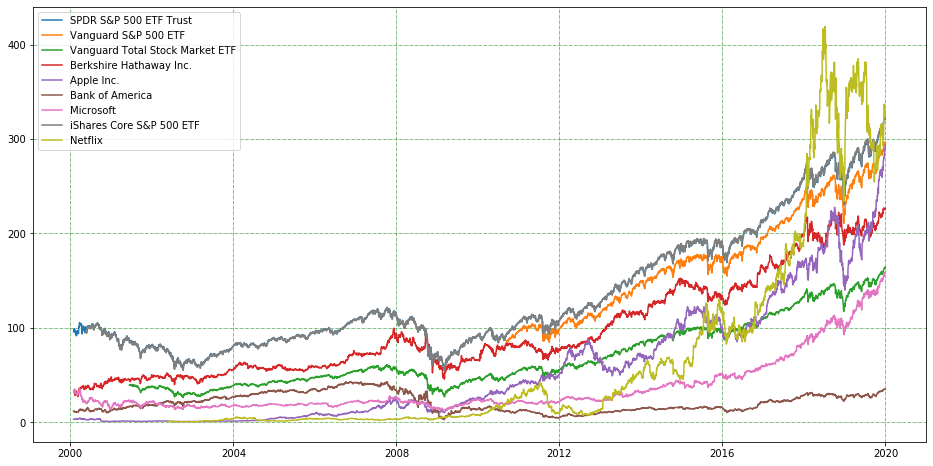

In [9]:
plt.figure(figsize=(16,8))
start_date='2000-01-31' 
for symb in iTickers:
    print(iTickers[symb])
    daa = get_historical_data(symb, start_date=start_date)
    sharpe_ratio = compute_sharpe(symb)
    #print(SP_500.loc[symb]['Name'], sharpe_ratio)
    print(iTickers[symb], sharpe_ratio)
    plt.plot(daa['Adj Close'])
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.legend([iTickers[sym] for sym in iTickers])
plt.savefig('well-known-tickers.png')

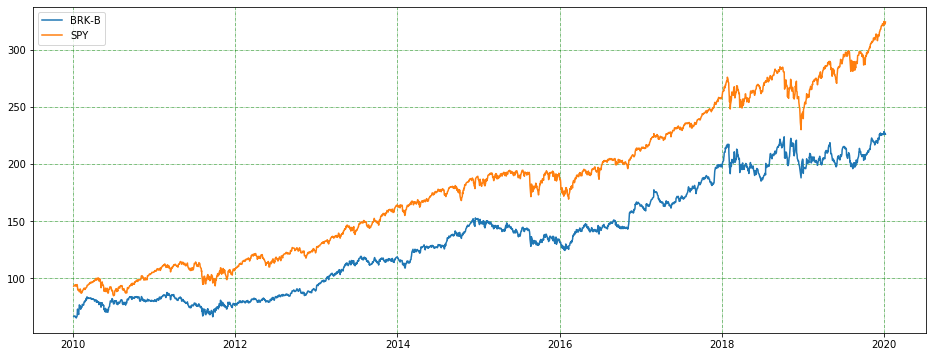

In [10]:
plt.figure(figsize=(16,6))
start_date='2010-01-02' 
end_date='2020-01-07' 
for symb in ['BRK-B','SPY']:
    daa = get_historical_data(symb, start_date=start_date, end_date=end_date)
    plt.plot(daa['Adj Close'])
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.legend(['BRK-B','SPY'])
plt.savefig('BRK_vs_SPY.png')

In [11]:
def plot_stock_price(stock, start_date='2019-01-02', end_date='2019-12-31', source='yahoo'):
    plt.figure(figsize=(16,6))
    daa = get_historical_data(stock, start_date=start_date, end_date=end_date, source=source)
    sharpe_ratio = compute_sharpe(stock)
    plt.plot(daa['Adj Close'])
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
    plt.legend([stock])
    plt.savefig('{}_{}_{}.png'.format(stock, start_date, end_date))

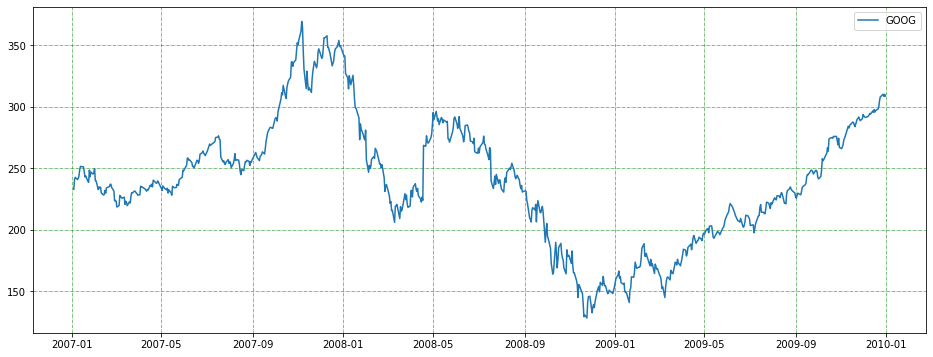

In [12]:
plot_stock_price('GOOG', start_date='2007-01-02', end_date='2010-01-02')

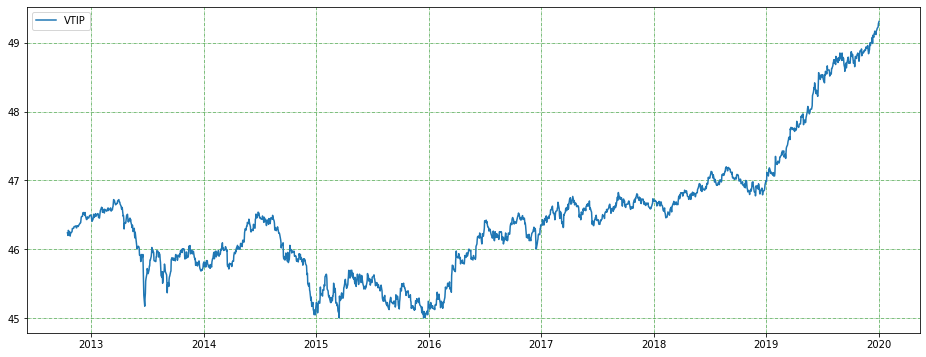

In [13]:
plot_stock_price('VTIP', start_date='1990-01-01', end_date='2020-01-01')

# Overall economic indicators

In [14]:
def plot_us_gdp(start_date = '1900-01-01', end_date = '2020-01-01'):
    plt.figure(figsize=(16,6))
    gdp_data = get_historical_data('GDP', start_date = start_date, end_date = end_date, source = 'fred')
    plt.plot(gdp_data)
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
    plt.legend(['US GDP'])
    plt.savefig('us_gdp.png')

In [15]:
def plot_us_inflation(start_date='1940-01-01', end_date='2020-01-01', index ='CPILFESL'):
    CPI  = get_historical_data(index, start_date = start_date, end_date = end_date, source = 'fred')
    CPI['CPI_Diff_monthly'] = CPI[index].diff()
    CPI['CPI_Diff_yearly'] = CPI[index].diff(12)
    CPI['CPI_monthly_inflation_rate'] = (CPI['CPI_Diff_monthly']/CPI[index])*100
    CPI['CPI_yearly_inflation_rate_pp'] = (CPI['CPI_Diff_yearly']/CPI[index])*100
    plt.figure(figsize=(16,6))
    plt.plot(CPI['CPI_monthly_inflation_rate'])
    plt.plot(CPI['CPI_yearly_inflation_rate_pp'])
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
    plt.legend(['US monthly inflation rate', 'US yearly point to point inflation rate'])
    plt.savefig('us_inflation_data_{}.png'.format(index))
    return CPI

In [16]:
def plot_index(index, start_date = '2010-01-02', end_date = '2020-01-02', source = 'fred'):
    indx  = get_historical_data(index, start_date, end_date, source)
    plt.figure(figsize=(16,6))
    plt.plot(indx)
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
    index_meaning = {'DGS10': 'US monthly interest rate (10-Year Treasury Constant Maturity Rate)', 
                     'FEDFUNDS': 'US Effective Federal Funds Rate',
                     'LIBOR': '3-Month London Interbank Offered Rate',
                     'NIKKEI225': 'Nikkei Stock Average, Nikkei 225',
                     'UNRATE': 'US Civilian Unemployment Rate',
                     'GFDEGDQ188S': 'Federal Debt: Total Public Debt as Percent of Gross Domestic Product',
                     'GDPC1': 'Real Gross Domestic Product percent change',
                     'A191RL1Q225SBEA': 'Real Gross Domestic Product dollars',
                     'CPIAUCSL': 'Consumer Price Index for All Urban Consumers: All Items',
                     'IRLTLT01JPM156N': 'Long-Term Government Bond Yields: 10-year: Japan'
                    }
    plt.legend([index_meaning[index]])
    plt.savefig('index_{}_{}_{}.png'.format(index, start_date, end_date))

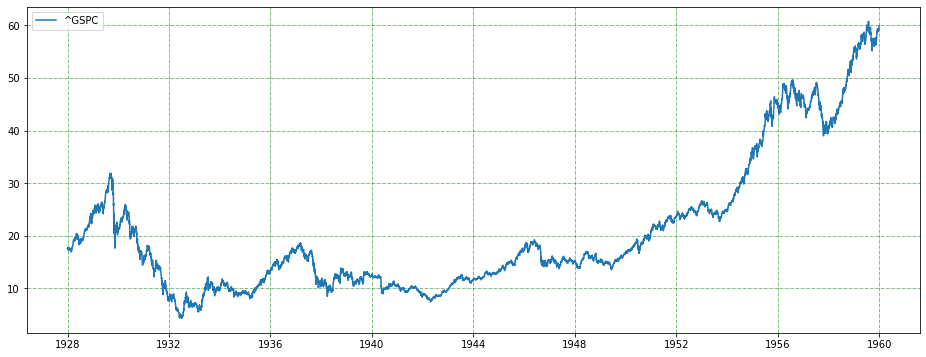

In [17]:
plot_stock_price('^GSPC', start_date='1900-01-01', end_date='1960-01-01')

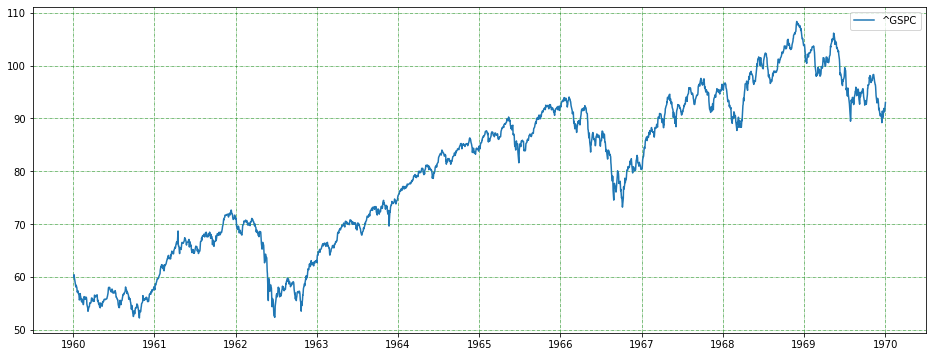

In [18]:
plot_stock_price('^GSPC', start_date='1960-01-01', end_date='1970-01-01')

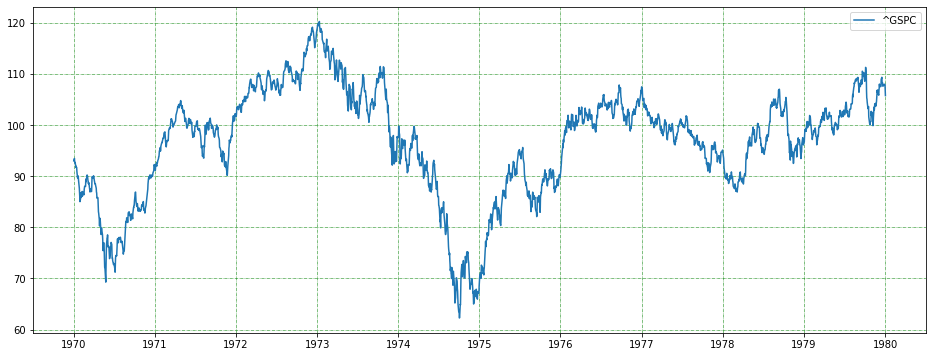

In [19]:
plot_stock_price('^GSPC', start_date='1970-01-01', end_date='1980-01-01')

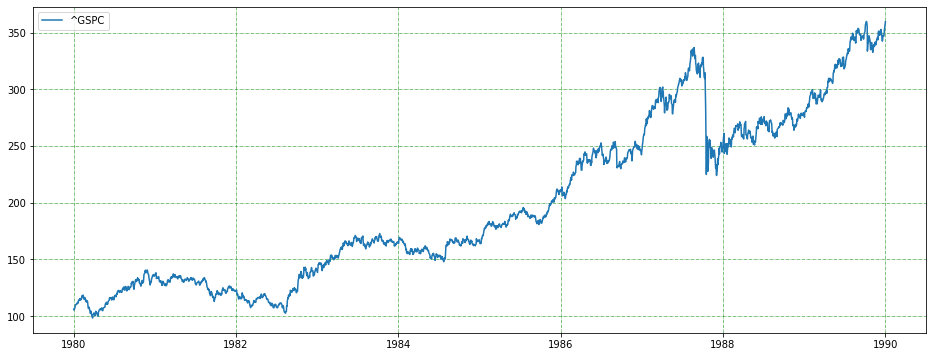

In [20]:
plot_stock_price('^GSPC', start_date='1980-01-01', end_date='1990-01-01')

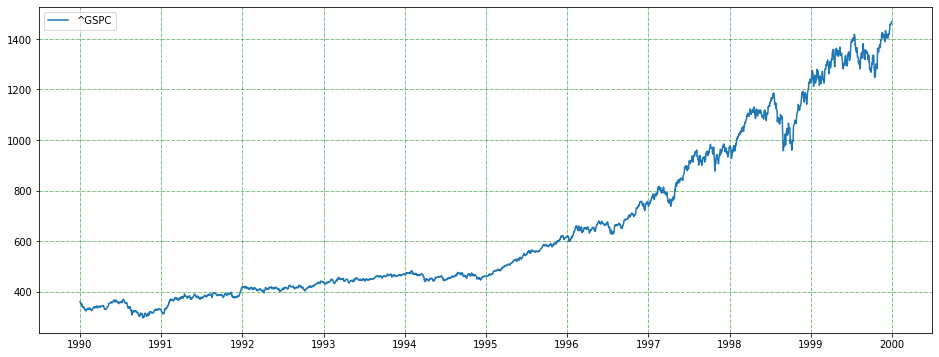

In [21]:
plot_stock_price('^GSPC', start_date='1990-01-01', end_date='2000-01-01')

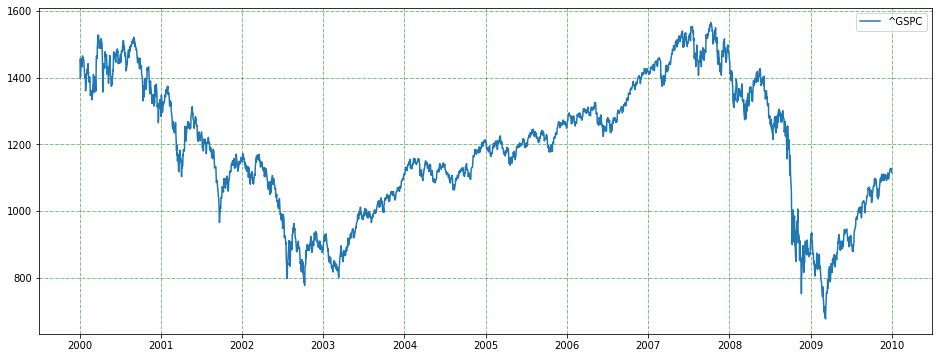

In [22]:
plot_stock_price('^GSPC', start_date='2000-01-01', end_date='2010-01-01')

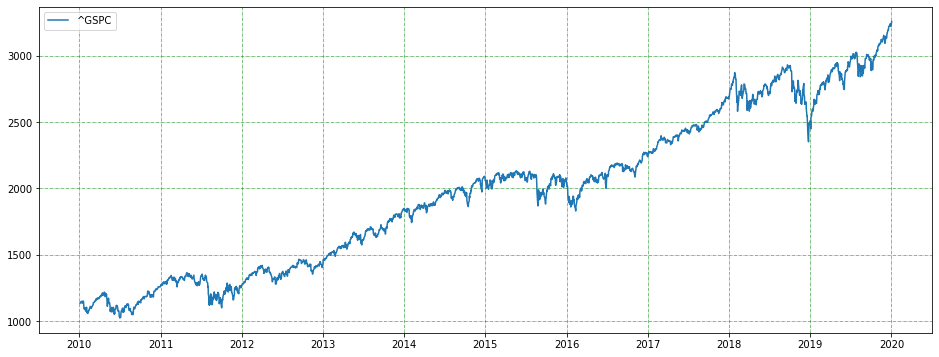

In [23]:
plot_stock_price('^GSPC', start_date='2010-01-01', end_date='2020-01-01')

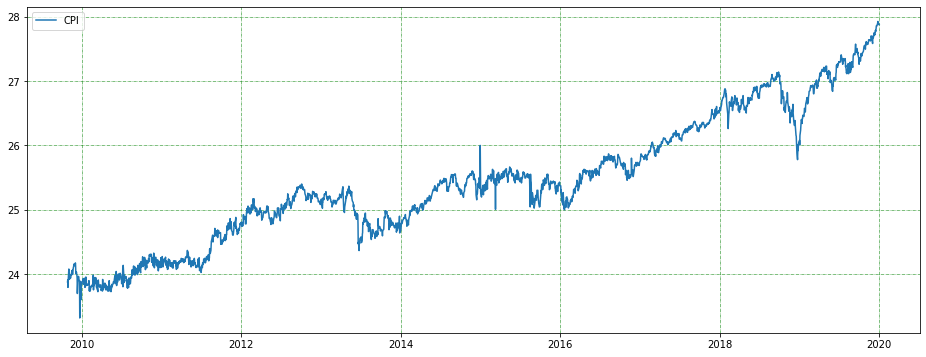

In [24]:
plot_stock_price('CPI', start_date='1990-01-01', end_date='2020-01-01')

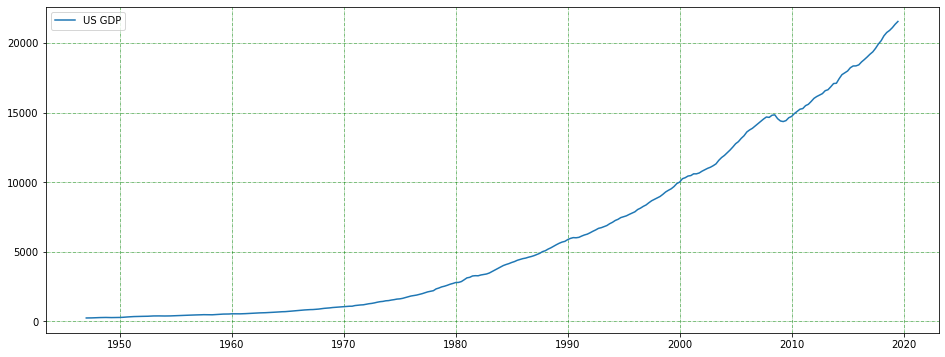

In [25]:
gdp = plot_us_gdp()

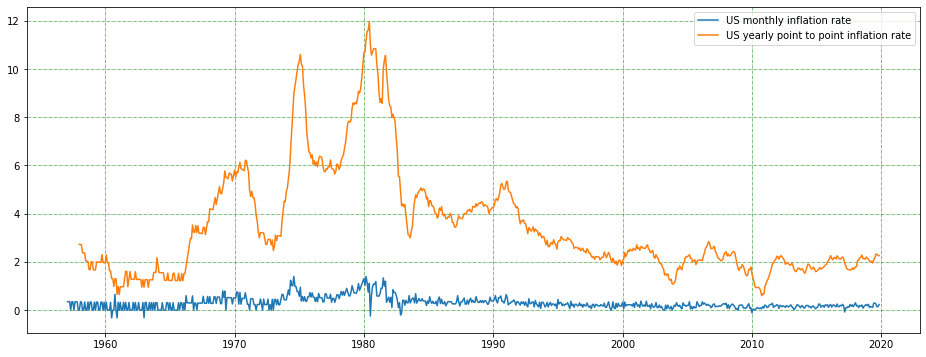

In [26]:
cpi_u_inflation_data = plot_us_inflation(index = 'CPILFESL')

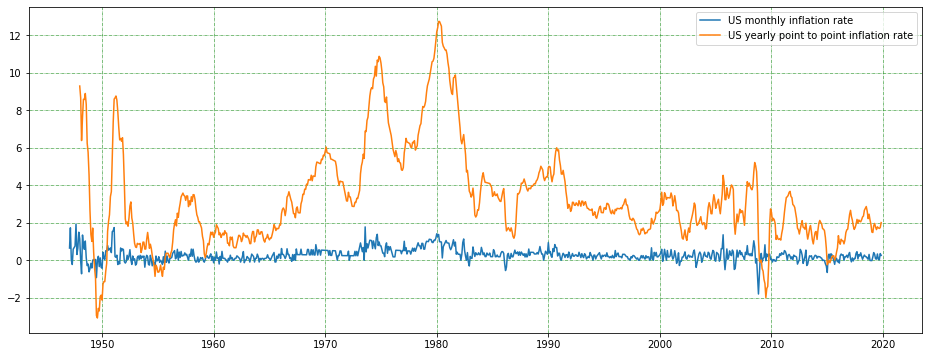

In [27]:
cpi_u_inflation_data = plot_us_inflation(index = 'CPIAUCSL')

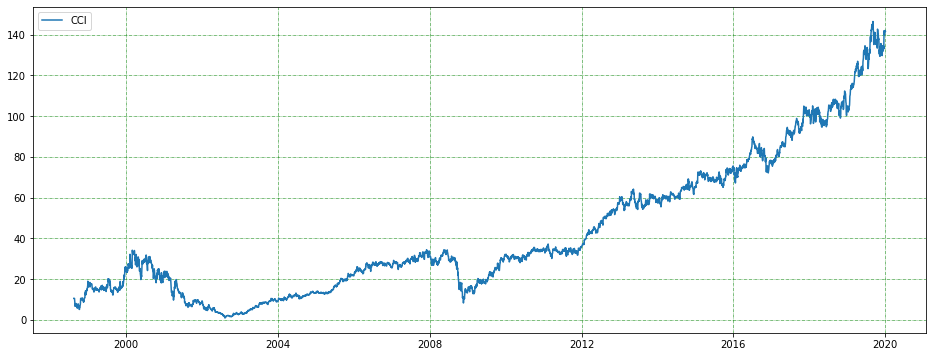

In [28]:
plot_stock_price('CCI', start_date='1960-01-01', end_date='2020-01-01')

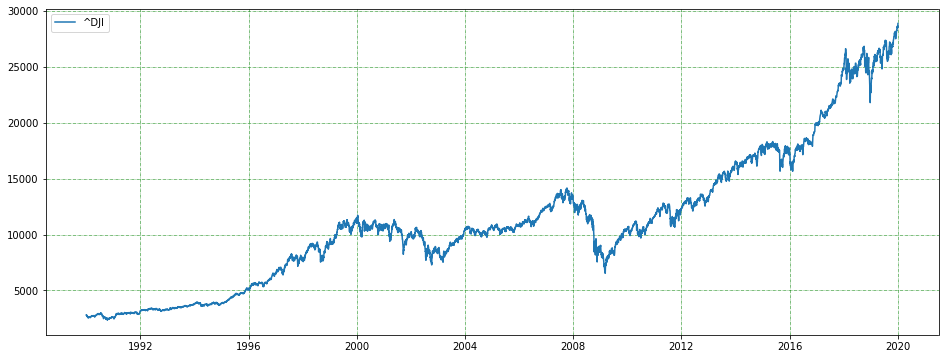

In [29]:
plot_stock_price('^DJI', start_date='1990-01-01', end_date='2020-01-01')

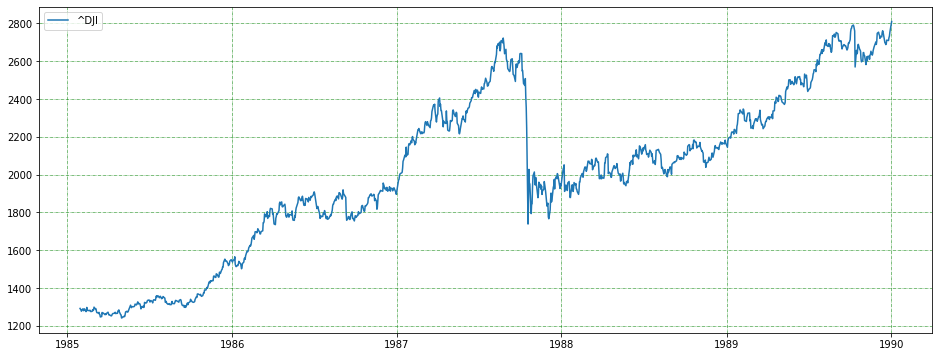

In [30]:
plot_stock_price('^DJI', start_date='1940-01-01', end_date='1990-01-01')

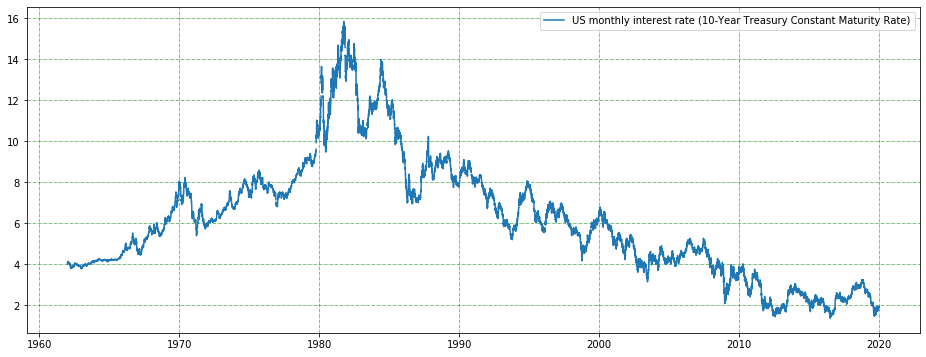

In [31]:
plot_index('DGS10', start_date = '1950-01-02')

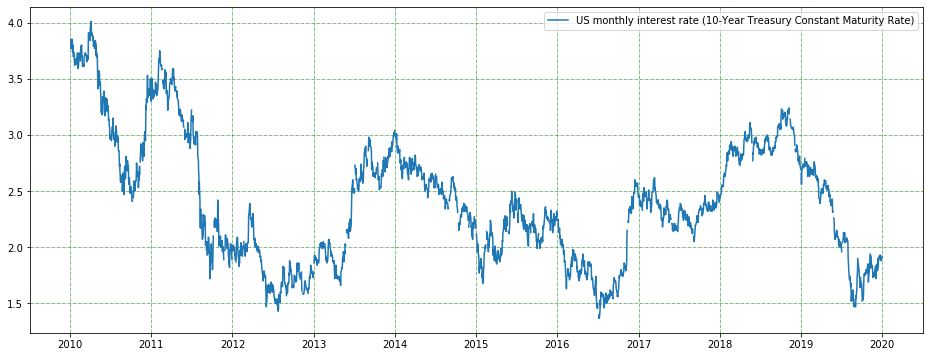

In [32]:
plot_index('DGS10', start_date = '2010-01-02')

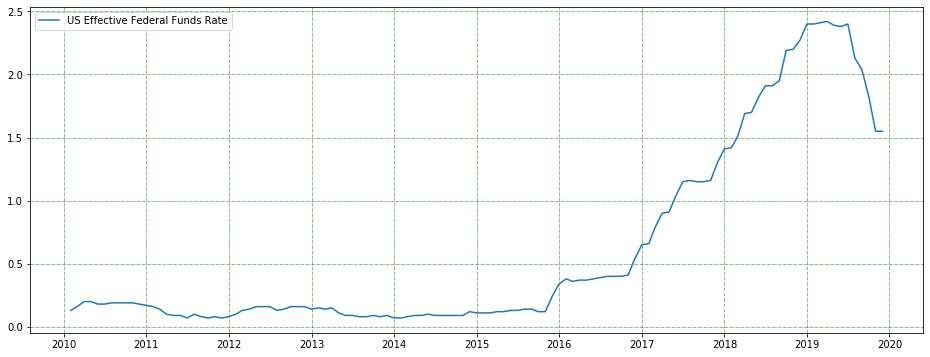

In [33]:
plot_index('FEDFUNDS')

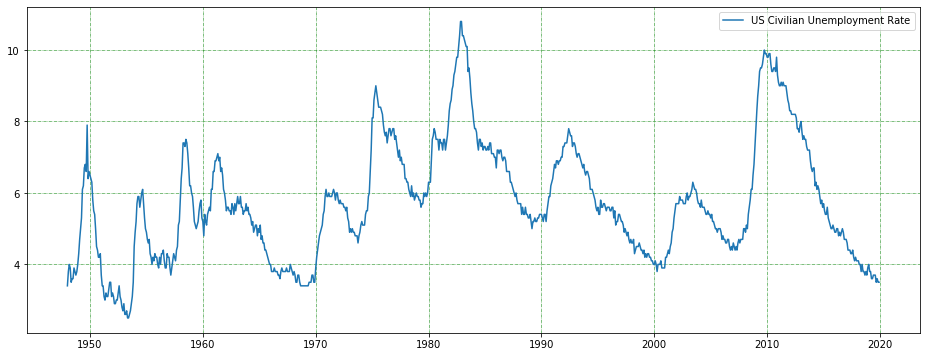

In [34]:
plot_index('UNRATE', start_date = '1910-01-02')

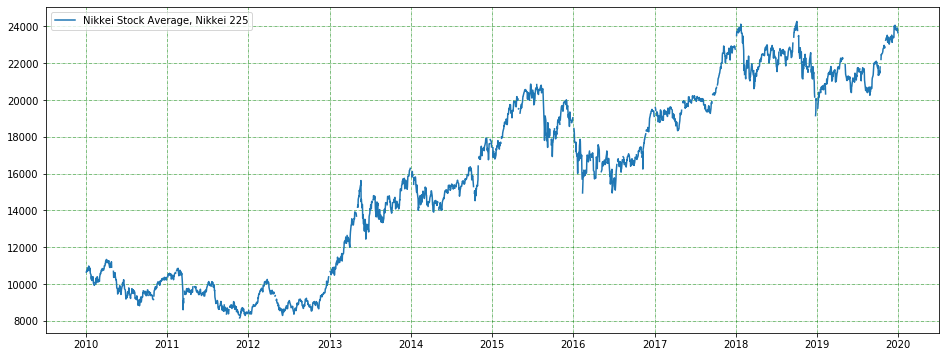

In [35]:
plot_index('NIKKEI225')

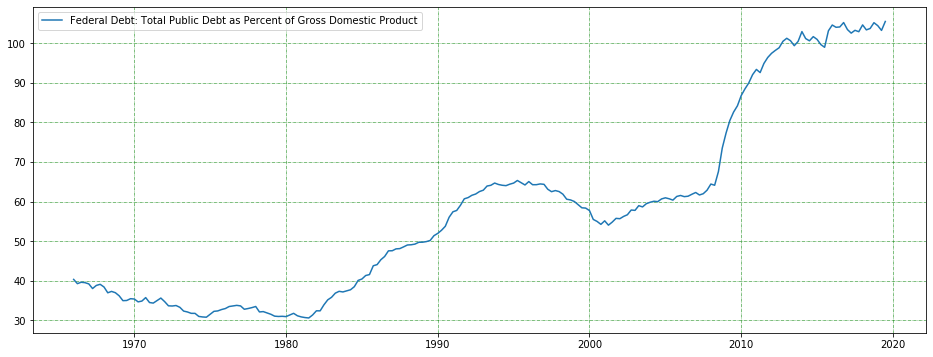

In [36]:
plot_index('GFDEGDQ188S', start_date = '1910-01-02')

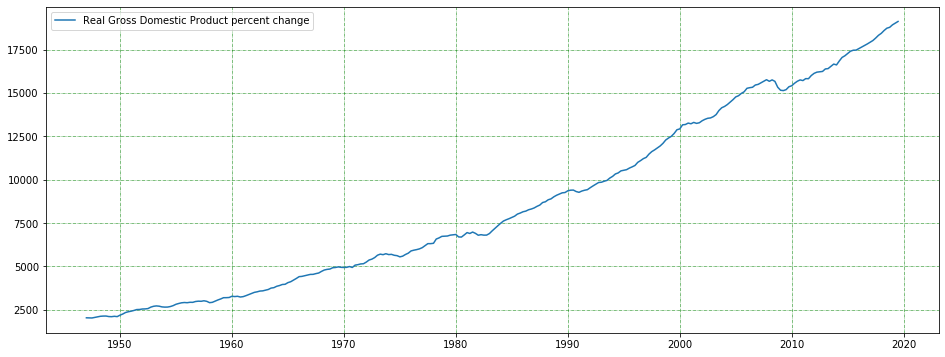

In [37]:
plot_index('GDPC1', start_date = '1910-01-02')

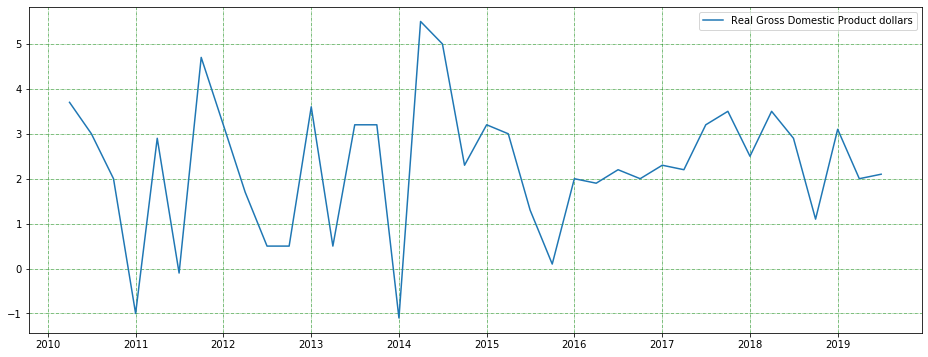

In [38]:
plot_index('A191RL1Q225SBEA', start_date = '2010-01-02')

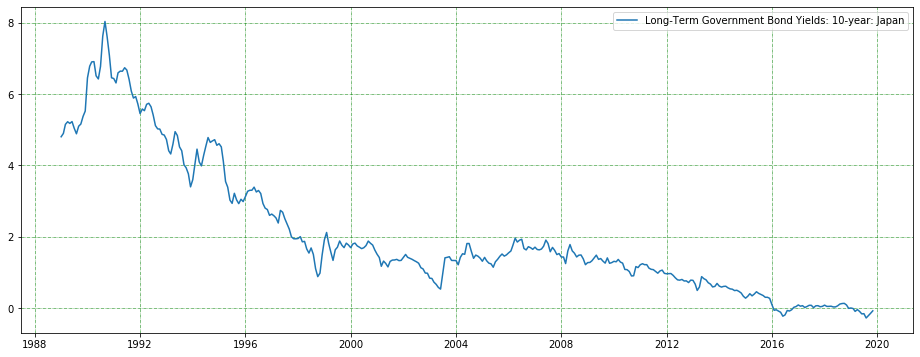

In [39]:
plot_index('IRLTLT01JPM156N', start_date = '1940-01-02')

In [40]:
nasdaq = data.get_nasdaq_symbols()
print(nasdaq.shape)
nasdaq.head()

(8904, 11)


,Nasdaq Traded,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
Symbol,,,,,,,,,,,
A,True,"Agilent Technologies, Inc. Common Stock",N,,False,100.0,False,NaN,A,A,False
AA,True,Alcoa Corporation Common Stock,N,,False,100.0,False,NaN,AA,AA,False
AAAU,True,Perth Mint Physical Gold ETF,P,,True,100.0,False,NaN,AAAU,AAAU,False
AACG,True,ATA Creativity Global - American Depositary Sh...,Q,G,False,100.0,False,N,NaN,AACG,False
AADR,True,AdvisorShares Dorsey Wright ADR ETF,P,,True,100.0,False,NaN,AADR,AADR,False


In [41]:
def compute_stats(symb):
    ticker = data.get_quote_yahoo(symb) 
    ticker['c1_marketCap_bn_calc'] = ticker['price'] * ticker['sharesOutstanding'] / 1e9
    ticker['c2_marketCap_bn_orig'] = ticker['marketCap'] / 1e9
    ticker['c3_price_calc'] = ticker['epsForward'] * ticker['trailingPE']
    ticker['c4_earnings_bn_calc'] = ticker['epsForward'] * ticker['sharesOutstanding'] / 1e9
    return ticker

In [42]:
compute_stats(['EXPE', 'GOOG', 'MSFT', 'AAPL', 'BB', 'JNPR', 'BRK-B', 'BRK-A'])

,language,region,quoteType,triggerable,quoteSourceName,currency,sharesOutstanding,bookValue,fiftyDayAverage,fiftyDayAverageChange,fiftyDayAverageChangePercent,twoHundredDayAverage,twoHundredDayAverageChange,twoHundredDayAverageChangePercent,marketCap,forwardPE,priceToBook,sourceInterval,exchangeDataDelayedBy,tradeable,firstTradeDateMilliseconds,priceHint,postMarketChangePercent,postMarketTime,postMarketPrice,postMarketChange,regularMarketChange,regularMarketChangePercent,regularMarketTime,regularMarketPrice,regularMarketDayHigh,regularMarketDayRange,regularMarketDayLow,regularMarketVolume,regularMarketPreviousClose,bid,ask,bidSize,askSize,fullExchangeName,financialCurrency,regularMarketOpen,averageDailyVolume3Month,averageDailyVolume10Day,fiftyTwoWeekLowChange,fiftyTwoWeekLowChangePercent,fiftyTwoWeekRange,fiftyTwoWeekHighChange,fiftyTwoWeekHighChangePercent,fiftyTwoWeekLow,fiftyTwoWeekHigh,dividendDate,earningsTimestamp,earningsTimestampStart,earningsTimestampEnd,trailingAnnualDividendRate,trailingPE,trailingAnnualDividendYield,marketState,epsTrailingTwelveMonths,epsForward,exchange,shortName,longName,messageBoardId,exchangeTimezoneName,exchangeTimezoneShortName,gmtOffSetMilliseconds,market,esgPopulated,price,c1_marketCap_bn_calc,c2_marketCap_bn_orig,c3_price_calc,c4_earnings_bn_calc
EXPE,en-US,US,EQUITY,True,Nasdaq Real Time Price,USD,139363008,28.758,107.789350,2.900650,0.026910,124.190370,-13.500366,-0.108707,15833431040,15.858167,3.849016,15,0,True,1121932800000,2,-0.126300,1.578693e+09,110.55,-0.139801,0.930000,0.847303,1578690001,110.69,111.0500,109.42 - 111.05,109.420,1781530,109.76,110.30,110.99,9,8,NasdaqGS,USD,109.8500,3324801,2212616,17.160004,0.183471,93.53 - 144.0,-33.309998,-0.231319,93.53,144.0000,1.576109e+09,1.573056e+09,1.580900e+09,1.581336e+09,1.30,33.140720,0.011844,CLOSED,3.340,6.98,NMS,"Expedia Group, Inc.","Expedia Group, Inc.",finmb_25915843,America/New_York,EST,-18000000,us_market,False,110.69,15.426091,15.833431,231.322226,0.972754
GOOG,en-US,US,EQUITY,True,Nasdaq Real Time Price,USD,343551008,282.193,1346.327100,83.402830,0.061948,1240.220500,189.509520,0.152803,986320732160,26.339905,5.066497,15,0,True,1092902400000,2,0.018886,1.578702e+09,1430.00,0.270020,9.900024,0.697268,1578690001,1429.73,1434.9292,1418.895 - 1434.9292,1418.895,1821566,1419.83,1429.05,1431.50,12,9,NasdaqGS,USD,1427.5600,1300890,1476150,404.729980,0.394859,1025.0 - 1434.9292,-5.199219,-0.003623,1025.00,1434.9292,NaN,NaN,NaN,NaN,NaN,30.680240,NaN,CLOSED,46.601,54.28,NMS,Alphabet Inc.,Alphabet Inc.,finmb_29096,America/New_York,EST,-18000000,us_market,False,1429.73,491.185183,986.320732,1665.323427,18.647949
MSFT,en-US,US,EQUITY,True,Nasdaq Real Time Price,USD,7695349760,13.893,154.927750,6.412247,0.041389,142.794680,18.545319,0.129874,1230832271360,26.579900,11.613043,15,0,True,511088400000,2,-0.024788,1.578704e+09,161.30,-0.039993,-0.750000,-0.462706,1578690001,161.34,163.2200,161.18 - 163.22,161.180,20733946,162.09,161.25,161.31,10,9,NasdaqGS,USD,162.8235,21717909,22552933,60.079994,0.593324,101.26 - 163.22,-1.880005,-0.011518,101.26,163.2200,1.583971e+09,1.571847e+09,1.580209e+09,1.580731e+09,1.89,30.441507,0.011660,CLOSED,5.300,6.07,NMS,Microsoft Corporation,Microsoft Corporation,finmb_21835,America/New_York,EST,-18000000,us_market,False,161.34,1241.567730,1230.832271,184.779947,46.710773
AAPL,en-US,US,EQUITY,True,Delayed Quote,USD,4384030208,20.365,280.050960,30.279022,0.108120,235.467300,74.862686,0.317932,1382380470272,20.730125,15.238399,15,0,True,345459600000,2,0.109569,1.578704e+09,310.67,0.340027,0.699982,0.226070,1578690001,310.33,312.6700,308.25 - 312.67,308.250,35217272,309.63,310.67,310.70,11,10,NasdaqGS,USD,310.6000,25849585,33802083,161.109990,1.079681,149.22 - 312.67,-2.340027,-0.007484,149.22,312.6700,1.573690e+09,1.580245e+09,1.580245e+09,1.580245e+09,3.00,26.100082,0.009689,CLOSED,11.890,14.97,NMS,Apple Inc.,Apple Inc.,finmb_24937,America/New_York,EST,-18000000,us_market,False,310.33,1360.496094,1382.380470,3